# Figures...

## Setup

In [2]:
%matplotlib inline

# Install libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os

In [ ]:
# Set input path
in_path = "~/Documents/2025.1-Deepfake Threat Landscape/2-analysis"

## Threat Actor Profiles

In [68]:
# Load data
df = pd.read_csv(os.path.join(in_path, "threat_actors.csv"))

df = df.drop('Count', axis=1)

In [70]:
# Define column groups
goal_cols = ["Entertain", "Experiment", "Deceive", "Harass", "Influence", "Provoke"]
motive_cols = ["Financial", "Political", "Sexual", "Social"]
harm_cols = ["Yes", "No"]
org_cols = ["Individual", "Group", "Institution"]
soph_cols = ["Rudimentary", "Sophisticated"]

# Column to group mapping
column_to_group = {
    "Entertain": "Goal",
    "Experiment": "Goal",
    "Deceive": "Goal",
    "Harass": "Goal",
    "Influence": "Goal",
    "Provoke": "Goal",

    "Financial": "Motive",
    "Political": "Motive",
    "Sexual": "Motive",
    "Social": "Motive",

    "Yes": "Harm Awareness",
    "No": "Harm Awareness",

    "Individual": "Organization",
    "Group": "Organization",
    "Institution": "Organization",

    "Rudimentary": "Sophistication",
    "Sophisticated": "Sophistication",
}


In [71]:
# Column-group normalization
def normalize_group(df, cols):
    df = df.copy()
    row_totals = df[cols].sum(axis=1)
    df[cols] = df[cols].div(row_totals.replace(0, np.nan), axis=0)
    df[cols] = df[cols].fillna(0)
    return df

df_norm = df.copy()

for cols in [goal_cols, motive_cols, harm_cols, org_cols, soph_cols]:
    df_norm = normalize_group(df_norm, cols)

In [84]:
# Pivot longer
df_long = (
    df_norm
    .melt(
        id_vars="Threat Actor",
        var_name="Dimension",
        value_name="Value"
    )
)

# Assign dimensions to groups
df_long["Group"] = df_long["Dimension"].map(column_to_group)

df_long["Group"] = pd.Categorical(df_long["Group"], categories=df_long["Group"].unique())

In [85]:
# Order the threat actors
actor_order = [
    "Fraudsters",
    "Commercial content creators",
    "Deepfake technology provider",
    "Political campaigner",
    "Satirist",
    "Sexualized deepfake creator (Adult)",
    "Sexualized deepfake creator (minor)",
    "Nation state",
    "State-aligned institutions",
    "Critical experimenters",
    "Socially motivated harassers",
    "Opportunistic deceivers",
    "Unknown"
]

group_order = [
    "Goal",
    "Motive",
    "Organization",
    "Harm Awareness",
    "Sophistication"
]

dimension_orders = {
    "Goal": goal_cols,
    "Motive": motive_cols,
    "Organization": org_cols,
    "Harm Awareness": harm_cols,
    "Sophistication": soph_cols
}

dimension_order_global = []
for g in group_order:
    dimension_order_global.extend(dimension_orders[g])

df_long["Threat Actor"] = pd.Categorical(
    df_long["Threat Actor"],
    categories=actor_order,
    ordered=True
)

df_long["Group"] = pd.Categorical(
    df_long["Group"],
    categories=group_order,
    ordered=True
)

df_long["Dimension"] = pd.Categorical(
    df_long["Dimension"],
    categories=dimension_order_global,
    ordered=True)

df_long = df_long.sort_values(by=["Threat Actor", "Group", "Dimension"])

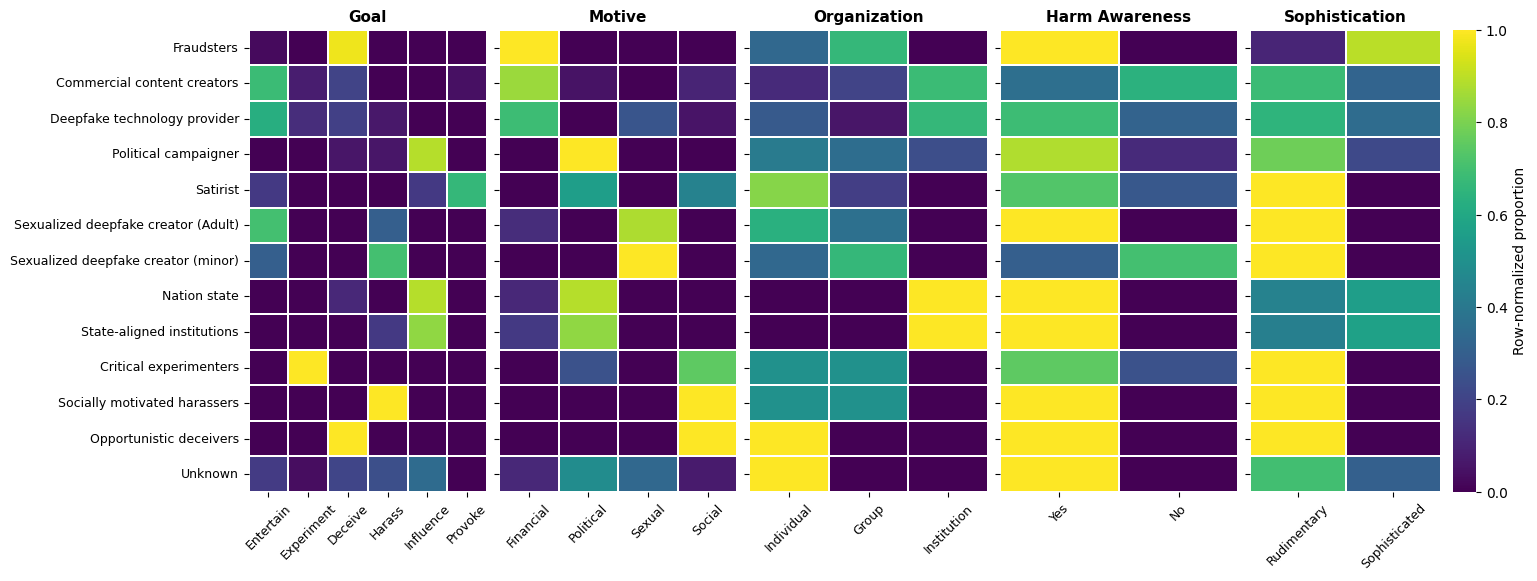

In [86]:
# Faceted heat map
groups = df_long["Group"].unique()

fig, axes = plt.subplots(
    1, len(groups),
    figsize=(16, 6),
    sharey=True,
    gridspec_kw={"wspace": 0.05}
)


cmap = plt.cm.viridis

for ax, group in zip(axes, groups):
    subset = df_long[df_long["Group"] == group]
    pivot = subset.pivot(
        index="Threat Actor",
        columns="Dimension",
        values="Value"
    )

    sns.heatmap(
        pivot,
        ax=ax,
        cmap=cmap,
        vmin=0,
        vmax=1,
        cbar=(ax == axes[-1]),
        linewidths=0.2,
        linecolor="white",
        square=False
    )

    ax.set_title(group, fontsize=11, fontweight="bold")
    ax.set_xlabel("")
    ax.set_ylabel("")

    ax.tick_params(axis="x", rotation=45, labelsize=9)
    ax.tick_params(axis="y", labelsize=9)

# Colorbar label
cbar = axes[-1].collections[0].colorbar
cbar.set_label("Row-normalized proportion", fontsize=10)

plt.savefig(
    os.path.join("../4-figures","threat_actor_profiles.png"),
    dpi=300,
    bbox_inches="tight",
    facecolor="white"
)

plt.show()

plt.close()